#  1. 产生tick日志

#####  编译最小main : 文件 mini_main.c
```cpp
//文件 mini_main.c
int main(int argc, char** argv){
    return 0;
}
```

```bash
tick_save=true /pubx/build-llvm15/bin/clang-15 -c mini_main.c
#生成tick日志文件:
#-rw-rw-r-- 1 zz zz 20M  7月 27 16:42 clang-15_252255_1690447364166_1
```

#####  编译最小main+含错误的f1: 文件 mini_main_f1_err.c
```cpp
//文件 mini_main_f1_err.c
char* calc_name(float age, bool high, char* nick){
  if(high && age>5){
    return "child";
  }
  char name[32]={"bigPeople"};
  return name;
}
int main(int argc, char** argv){
	calc_name(10,false,"nick");
    return 0;
}
```

```bash
tick_save=true /pubx/build-llvm15/bin/clang-15 -c mini_main_f1_err.c
#生成tick日志文件:
#-rw-rw-r-- 1 zz zz 17M  7月 27 17:54 clang-15_268265_1690451684154_1
```

#####  编译最小main+正确的f1: 文件 mini_main_f1_ok.c
```cpp
//文件 mini_main_f1_ok.c
char* calc_name(float age, short high, char* nick){
  if(high && age>5){
    return "child";
  }
  char name[32]={"bigPeople"};
  return name;
}
int main(int argc, char** argv){
	calc_name(10,0,"nick");
    return 0;
}
```

```bash
tick_save=true /pubx/build-llvm15/bin/clang-15 -c mini_main_f1_ok.c
#生成tick日志文件:
#-rw-rw-r-- 1 zz zz 23M  7月 27 18:35 clang-15_272726_1690454100567_1
```

#####  编译、链接最小main: 文件 mini_main_f1_ok.c

```bash
tick_save=true /pubx/build-llvm15/bin/clang-15  mini_main.c
# -rw-rw-r--  5.0M  7月 27 19:08 clang-15_279682_1690456088057_1  #编译、链接最小main正常中的编译步骤?(注意看时刻先后)
# -rw-rw-r--  19M   7月 27 19:08 clang-15_279683_1690456088122_1  #编译、链接最小main正常中的链接步骤?

#为何编译、链接 两步一起，中 第二步  和 单独一步骤编译 的 轨迹 是类似的？
```


# 2. 分析tick日志

In [1]:
import numpy 
import math

In [2]:
import seaborn

In [3]:
import plotly.offline as plotly_offline
plotly_offline.init_notebook_mode(connected=True)          
import plotly.graph_objs as graph_objs                
import plotly.figure_factory as figure_factory 

from plotly.graph_objs import Scatter, Figure, Scatter3d



In [4]:
import pandas
# pandas.options.display.max_columns = None
# pandas.options.display.max_rows = None

In [5]:
%%bash
ls -lhrt ./tick_data_home/

总计 109M
-rw-rw-r-- 1 zz zz  20M  7月 27 16:42 clang-15_252255_1690447364166_1
-rw-rw-r-- 1 zz zz  17M  7月 27 17:54 clang-15_268265_1690451684154_1
-rw-rw-r-- 1 zz zz  23M  7月 27 18:35 clang-15_272726_1690454100567_1
-rw-rw-r-- 1 zz zz  19M  7月 27 19:08 clang-15_279683_1690456088122_1
-rw-rw-r-- 1 zz zz 5.0M  7月 27 19:08 clang-15_279682_1690456088057_1
-rw-rw-r-- 1 zz zz  22M  7月 27 19:08 clang-15_279758_1690456131168_1
-rw-rw-r-- 1 zz zz 5.0M  7月 27 19:08 clang-15_279757_1690456131110_1


In [6]:
#编译正常: mini_main.c
df1=pandas.read_csv(filepath_or_buffer="./tick_data_home/clang-15_252255_1690447364166_1",sep=',')

#编译错误: mini_main_f1_err.c
df2=pandas.read_csv(filepath_or_buffer="./tick_data_home/clang-15_268265_1690451684154_1",sep=',')

#编译正常: mini_main_f1_ok.c
df3=pandas.read_csv(filepath_or_buffer="./tick_data_home/clang-15_272726_1690454100567_1",sep=',')

#编译、链接mini_main.c  ， 共有两个clang进程，
#第一个clang进程产生的tick日志如下：
df4=pandas.read_csv(filepath_or_buffer="./tick_data_home/clang-15_279682_1690456088057_1",sep=',')
#第二个clang进程产生的tick日志如下：
df4B=pandas.read_csv(filepath_or_buffer="./tick_data_home/clang-15_279683_1690456088122_1",sep=',')

In [7]:
df1.head()

,滴答,栈生,栈死,栈净,堆生,堆死,堆净
0,1,1,0,1,0,0,0
1,2,0,0,1,0,0,0
2,3,0,0,1,0,0,0
3,4,0,0,1,0,0,0
4,5,1,0,2,0,0,0


In [8]:
# df1_=df1
# df2_=df2
# df3_=df3

#tick日志特别的密集，这里间隔200个tick采样一次，方便输出观看，否则容易浏览器卡死 图出不来。
df1=df1[::200]  #pandas.Dataframe间隔200行采样1行
df2=df2[::200]  
df3=df3[::200]  
df4=df4[::200]  
df4B=df4B[::200]  

### 2.1  seaborn作图: 明显看出轨迹的共同部分和差异部分

<AxesSubplot:xlabel='滴答', ylabel='栈净'>

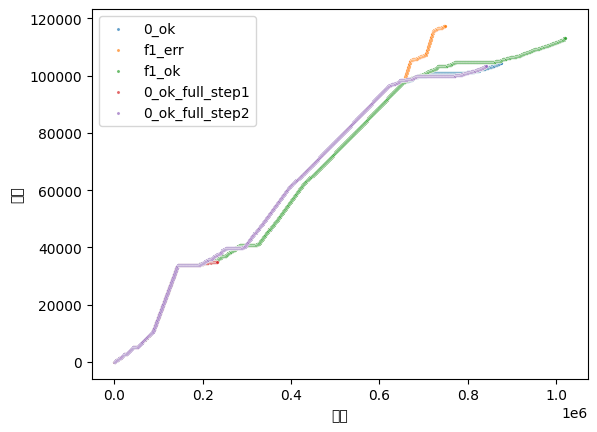

In [9]:

import warnings
# 过滤掉RuntimeWarning警告
warnings.filterwarnings("ignore", category=RuntimeWarning)


#seaborn作图会留在 .ipynb文件内，网页上浏览代码仓库中 此 .ipynb文件 即可看到 seaborn图，方便。
seaborn.scatterplot(x='滴答', y='栈净' , data=df1, alpha=0.7, s=5, label='0_ok')  #alpha=0.9,size=1, 
seaborn.scatterplot(x='滴答', y='栈净' , data=df2, alpha=0.7, s=5, label='f1_err')
seaborn.scatterplot(x='滴答', y='栈净' , data=df3, alpha=0.7, s=5, label='f1_ok')
seaborn.scatterplot(x='滴答', y='栈净' , data=df4, alpha=0.7, s=5, label='0_ok_full_step1')
seaborn.scatterplot(x='滴答', y='栈净' , data=df4B, alpha=0.7, s=5, label='0_ok_full_step2')


### 2.2  plotly作图 , 结果当然是和 seaborn一样了

> plotly作图 不会留在 .ipynb文件内，但比seaborn清晰。

In [10]:


栈净1_trace = graph_objs.Scatter(
 x = df1.滴答,
 y = df1.栈净,
 showlegend=True,
mode = 'markers',
marker=dict(size=2),
name="栈净1_最小main编译正常"
)


栈净2_trace = graph_objs.Scatter(
 x = df2.滴答,
 y = df2.栈净,
 showlegend=True,
mode = 'markers',
marker=dict(size=2),
name="栈净2_编译f1报错"
)

栈净3_trace = graph_objs.Scatter(
 x = df3.滴答,
 y = df3.栈净,
 showlegend=True,
mode = 'markers',
marker=dict(size=2),
name="栈净3_编译f1正常"
)

栈净4_trace = graph_objs.Scatter(
 x = df4.滴答,
 y = df4.栈净,
 showlegend=True,
mode = 'markers',
marker=dict(size=2),
name="栈净4_编译、链接最小main正常中的步骤1"
)

栈净4B_trace = graph_objs.Scatter(
 x = df4B.滴答,
 y = df4B.栈净,
 showlegend=True,
mode = 'markers',
marker=dict(size=2),
name="栈净4B_编译、链接最小main正常中的步骤2"
)

#浏览器:
# plotly_offline.iplot([栈生_trace,栈死_trace])
# plotly_offline.iplot([ 栈净_trace])
plotly_offline.iplot([ 栈净1_trace,栈净2_trace,栈净3_trace,栈净4_trace,栈净4B_trace])
plotly_offline.iplot([ 栈净1_trace ])




###### 开发中可能用到的其他代码：

In [11]:
# 栈生_trace = graph_objs.Scatter(
#  x = df.滴答,
#  y = df.栈生,
#  showlegend=True,
# mode = 'lines+markers',
# line=dict(width=1),
# marker=dict(size=1),
# name="栈生"
# )

# 栈死_trace = graph_objs.Scatter(
#  x = df.滴答,
#  y = df.栈死,
#  showlegend=True,
# # mode = 'lines+markers',
# mode = 'markers',
# line=dict(width=1),
# marker=dict(size=1),
# name="栈死"
# )